# BangleBeat

The following notebook walks through the process of making a machine learning model to improve BangleJS2 heart rate accuracy based on prior data. The ML model runs directly on the BangleJS2 watch and should serve as an easy to use pipeline for folks to make thier own Bangle more accurate for them. Further work may attempt to generalize this approach to yield an open source watch which actively learns how to improve its own heart rate measurements. 



## Data Capture

First, we should assess how good or bad the BangleJS2 performs when compared to other wearable devices. This includes the following devices:

- BangleJS2 Smart Watch
- Garmin Instinct 2X Smart Watch
- Polar H10 ECG Chest Strap

These are all supported to a sufficient degree by [Gadgetbridge](https://gadgetbridge.org/). However, in the initial phases of this project I found that the BangleJS2 does not sample heart rate data nearly as fast as the Garmin does. To give this model a fighting chance I wrote [loglog](https://github.com/lucspec/BangleApps/tree/master/apps/loglog) -- a BangleJS2 app to prioritize data collection over battery life. Initial testing yields a high enough data density to be more comprable with the other two sensors in this work.

## Analysis

With our sensors and collection mechanisms in place, we can start looking at some data.

In [24]:
import sys
import sqlite3
from datetime import datetime, timedelta
import os
from typing import Optional, List
from pathlib import Path
import pandas as pd

try:
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    import seaborn as sns
except ImportError as e:
    print(f"Error: {e}")
    print("Run: poetry install --with analysis")
    sys.exit(1)

from lib.hrDataLoaders import getGadgetbridgeData, getLoglogData, getLoglogCsv

With some boilerplate out of the way, let's load up our data and see what we have.

In [33]:
#!/usr/bin/env python3
"""
Load Gadgetbridge Heart Rate Data - Bare Script
Output: gb_data DataFrame
"""

import sqlite3
import pandas as pd
from datetime import datetime

# =============================================================================
# CONFIGURATION
# =============================================================================
DB_PATH = "./data/Gadgetbridge.db"
START_DATE = None  # Optional: 'YYYY-MM-DD'
END_DATE = None    # Optional: 'YYYY-MM-DD'

# =============================================================================
# LOAD DEVICE LIST
# =============================================================================
conn = sqlite3.connect(DB_PATH)

query = """
SELECT 
    _id as id,
    NAME as name,
    MANUFACTURER as mfg,
    IDENTIFIER as identifier,
    TYPE as type,
    TYPE_NAME as type_name,
    MODEL as model
FROM DEVICE
ORDER BY _id
"""

devices = pd.read_sql_query(query, conn)

## Optional -- show all devices in gadgetbridge db
#print("="*100)
#print("GADGETBRIDGE DEVICES")
#print("="*100)
#print(devices.to_string(index=False))
#print()

# =============================================================================
# MAP DEVICE TYPES TO TABLES
# =============================================================================
type_to_table = {
    'GARMIN_INSTINCT_2X_SOLAR': 'GARMIN_ACTIVITY_SAMPLE',
    'BANGLEJS': 'BANGLE_JSACTIVITY_SAMPLE',
    'POLAR': 'POLAR_H10_ACTIVITY_SAMPLE',
}

# =============================================================================
# LOAD HR DATA FROM ALL DEVICES
# =============================================================================
dataframes = []

for _, device in devices.iterrows():
    device_id = device['id']
    device_name = device['name']
    device_type = device['type_name']
    
    # Determine table name
    table_name = None
    
    # Try exact match first
    if device_type in type_to_table:
        table_name = type_to_table[device_type]
    # Try partial matches for variations
    elif 'GARMIN' in device_type:
        table_name = 'GARMIN_ACTIVITY_SAMPLE'
    elif 'BANGLE' in device_type:
        table_name = 'BANGLE_JSACTIVITY_SAMPLE'
    elif 'POLAR' in device_type:
        table_name = 'POLAR_H10_ACTIVITY_SAMPLE'

    if not table_name:
        ## Optional -- warn when we see devices we don't expect 
        #print(f"Warning: Unknown device type '{device_type}' for device '{device_name}', skipping")
        continue
    
    # Check if table exists
    cursor = conn.cursor()
    cursor.execute("""
        SELECT name FROM sqlite_master 
        WHERE type='table' AND name=?
    """, (table_name,))
    
    if not cursor.fetchone():
        # Optional -- warn when we can't find a table for an unknown device
        #print(f"Warning: Table '{table_name}' not found for device '{device_name}', skipping")
        continue
    
    # Build query
    query = f"""
    SELECT
        ? as device_id,
        ? as device_name,
        ? as device_type,
        TIMESTAMP,
        HEART_RATE
    FROM {table_name}
    WHERE DEVICE_ID = ? AND HEART_RATE IS NOT NULL AND HEART_RATE > 0
    """
    
    params = [device_id, device_name, device_type, device_id]
    
    if START_DATE:
        timestamp = int(datetime.strptime(START_DATE, "%Y-%m-%d").timestamp())
        query += " AND TIMESTAMP >= ?"
        params.append(timestamp)
    if END_DATE:
        timestamp = int(datetime.strptime(END_DATE, "%Y-%m-%d").timestamp())
        query += " AND TIMESTAMP <= ?"
        params.append(timestamp)
    
    query += " ORDER BY TIMESTAMP"
    
    try:
        df = pd.read_sql_query(query, conn, params=params)
        if not df.empty:
            df['datetime'] = pd.to_datetime(df['TIMESTAMP'], unit='s')
            dataframes.append(df)
            print(f"✓ Loaded {len(df):,} measurements from {device_name} ({device_type})")
    except Exception as e:
        print(f"✗ Could not load data for {device_name}: {e}")

conn.close()

# =============================================================================
# COMBINE ALL DATA
# =============================================================================
if dataframes:
    gb_data = pd.concat(dataframes, ignore_index=True)
    gb_data = gb_data.sort_values('datetime').reset_index(drop=True)
    
    print()
    print("="*80)
    print("GADGETBRIDGE DATA LOADED")
    print("="*80)
    print(f"Total measurements: {len(gb_data):,}")
    print(f"Date range: {gb_data['datetime'].min()} to {gb_data['datetime'].max()}")
    print()
    print("By device:")
    for device in gb_data['device_name'].unique():
        count = len(gb_data[gb_data['device_name'] == device])
        device_type = gb_data[gb_data['device_name'] == device]['device_type'].iloc[0]
        print(f"  - {device} ({device_type}): {count:,}")
else:
    print("No Gadgetbridge data loaded!")
    gb_data = pd.DataFrame()

✓ Loaded 163,033 measurements from Instinct 2X Solar (GARMIN_INSTINCT_2X_SOLAR)
✓ Loaded 26 measurements from Bangle.js db9a (BANGLEJS)
✓ Loaded 17,545 measurements from Polar H10 CC3A8829 (POLARH10)

GADGETBRIDGE DATA LOADED
Total measurements: 180,604
Date range: 2025-06-08 14:12:00 to 2025-11-16 07:22:04

By device:
  - Instinct 2X Solar (GARMIN_INSTINCT_2X_SOLAR): 163,033
  - Bangle.js db9a (BANGLEJS): 26
  - Polar H10 CC3A8829 (POLARH10): 17,545


In [43]:
import os
import pandas as pd
from datetime import datetime

# =============================================================================
# CONFIGURATION
# =============================================================================
CSV_PATH = "./data/loglog.csv"
DEVICE_NAME = 'banglejs2-loglog'
START_DATE = None  # Optional: 'YYYY-MM-DD'
END_DATE = None    # Optional: 'YYYY-MM-DD'

# =============================================================================
# LOAD CSV WITH ENCODING HANDLING
# =============================================================================
if not os.path.exists(CSV_PATH):
    print(f"✗ Error: CSV file not found: {CSV_PATH}")
    loglog_data = pd.DataFrame()
else:
    try:
        # Try latin-1 encoding (handles 0xb5 µ symbol)
        df = pd.read_csv(CSV_PATH, encoding='latin-1')
        
        # Clean and rename columns
        df.columns = df.columns.str.strip()
        df = df.rename(columns={
            'Epoch (ms)': 'EPOCH_MS',
            'Battery': 'battery',
            'X': 'x',
            'Y': 'y',
            'Z': 'z',
            'Total': 'total_accel',
            'BPM': 'HEART_RATE',
            'Confidence': 'confidence'
        })
        
        # Filter valid heart rate data
        df = df[df['HEART_RATE'].notna() & (df['HEART_RATE'] > 0)]
        
        # Convert timestamps
        df['TIMESTAMP'] = pd.to_numeric(df['EPOCH_MS'], errors='coerce') / 1000
        df['datetime'] = pd.to_datetime(df['TIMESTAMP'], unit='s', errors='coerce')
        df = df[df['datetime'].notna()]
        
        # Add device metadata
        df['device_name'] = DEVICE_NAME
        df['device_type'] = 'LOGLOG_CSV'
        df['device_id'] = 999
        
        # Date filtering
        if START_DATE:
            df = df[df['datetime'] >= datetime.strptime(START_DATE, "%Y-%m-%d")]
        if END_DATE:
            df = df[df['datetime'] <= datetime.strptime(END_DATE, "%Y-%m-%d")]
        
        loglog_data = df
        
        print("="*80)
        print("LOGLOG DATA LOADED")
        print("="*80)
        print(f"Device: {DEVICE_NAME}")
        print(f"Total measurements: {len(loglog_data):,}")
        print(f"Date range: {loglog_data['datetime'].min()} to {loglog_data['datetime'].max()}")
        print(f"Heart rate range: {loglog_data['HEART_RATE'].min():.0f} - {loglog_data['HEART_RATE'].max():.0f} bpm")
        print(f"Heart rate mean: {loglog_data['HEART_RATE'].mean():.1f} bpm")
        
        # Accelerometer data availability
        if 'x' in loglog_data.columns:
            accel_complete = loglog_data[['x', 'y', 'z']].notna().all(axis=1).sum()
            print(f"Accelerometer samples: {accel_complete:,}")
            if accel_complete > 0:
                print(f"  X range: {loglog_data['x'].min():.0f} to {loglog_data['x'].max():.0f}")
                print(f"  Y range: {loglog_data['y'].min():.0f} to {loglog_data['y'].max():.0f}")
                print(f"  Z range: {loglog_data['z'].min():.0f} to {loglog_data['z'].max():.0f}")
        
        # Battery info
        if 'battery' in loglog_data.columns and loglog_data['battery'].notna().any():
            print(f"Battery range: {loglog_data['battery'].min():.0f}% - {loglog_data['battery'].max():.0f}%")
        
        # Confidence info
        if 'confidence' in loglog_data.columns and loglog_data['confidence'].notna().any():
            # Bin confidence into low/medium/high
            LOW = 40
            MED = 80
            conf_values = loglog_data['confidence']
            count = len(conf_values)
            low    = ((conf_values >= 0)   & (conf_values < LOW)).sum()
            medium = ((conf_values >= LOW) & (conf_values < MED)).sum()
            high   = (conf_values >= MED).sum()
            print(f"Confidence: Low (0-{LOW}): {low/count*100:.1f}, Medium ({LOW}-{MED}): {medium/count*100:.1f}, High ({MED}+): {high/count*100:.1f}")
        
        print()
        
    except Exception as e:
        print(f"✗ Error loading CSV: {e}")
        loglog_data = pd.DataFrame()

LOGLOG DATA LOADED
Device: banglejs2-loglog
Total measurements: 17,752
Date range: 2025-11-17 06:42:05.175050020 to 2025-11-17 13:08:50.545600176
Heart rate range: 52 - 107 bpm
Heart rate mean: 62.2 bpm
Accelerometer samples: 0
Battery range: 63% - 98%
Confidence: Low (0-40): 4.0, Medium (40-80): 9.4, High (80+): 86.6



In [56]:
#!/usr/bin/env python3
"""
Combine and Normalize HR Data - Bare Script
Input: gb_data, loglog_data (or any DataFrames with HR data)
Output: hr_data (combined and normalized)
"""

import pandas as pd

# =============================================================================
# CONFIGURATION
# =============================================================================
MIN_HR = 0    # Minimum heart rate for normalization
MAX_HR = 200  # Maximum heart rate for normalization
DATE_FMT = '%Y-%m-%d'

# =============================================================================
# COMBINE DATA FROM MULTIPLE SOURCES
# =============================================================================
print(f'{"="*80}\nCOMBINING DATA SOURCES\n{"="*80}')

# List of dataframes to combine (add or remove as needed)
dfs_to_combine = []

# Add Gadgetbridge data if it exists and is not empty
if 'gb_data' in locals() and not gb_data.empty:
    dfs_to_combine.append(gb_data)
    print(f"✓ Including Gadgetbridge data: {len(gb_data):,} measurements")

# Add Loglog data if it exists and is not empty  
if 'loglog_data' in locals() and not loglog_data.empty:
    dfs_to_combine.append(loglog_data)
    print(f"✓ Including Loglog data: {len(loglog_data):,} measurements")

# Combine all dataframes
if dfs_to_combine:
    hr_data = pd.concat(dfs_to_combine, ignore_index=True)
    hr_data = hr_data.sort_values('datetime').reset_index(drop=True)
    
    print(f"\nTotal combined measurements: {len(hr_data):,}")
    print(f"Date range: {hr_data['datetime'].min().strftime(DATE_FMT)} to {hr_data['datetime'].max().strftime(DATE_FMT)}")
    
else:
    print("✗ No data to combine!")
    hr_data = pd.DataFrame()


COMBINING DATA SOURCES
✓ Including Gadgetbridge data: 180,604 measurements
✓ Including Loglog data: 17,752 measurements

Total combined measurements: 198,356
Date range: 2025-06-08 to 2025-11-17


In [57]:
print("\nDevices in combined data:")
for device in hr_data['device_name'].unique():
    device_data = hr_data[hr_data['device_name'] == device]
    count = len(device_data)
    device_type = device_data['device_type'].iloc[0]
    date_range = device_data['datetime']
    hr_range = device_data['HEART_RATE']
    
    print(f"\n  {device} ({device_type}):")
    print(f"    Measurements: {count:,}")
    print(f"    Date range: {date_range.min().strftime('%Y-%m-%d %H:%M')} to {date_range.max().strftime('%Y-%m-%d %H:%M')}")
    print(f"    HR range: {hr_range.min():.0f} - {hr_range.max():.0f} bpm (mean: {hr_range.mean():.1f})")
    
    # Show accelerometer data if available
    if 'x' in device_data.columns:
        accel_complete = device_data[['x', 'y', 'z']].notna().all(axis=1).sum()
        if accel_complete > 0:
            print(f"    Accelerometer: {accel_complete:,} samples")


Devices in combined data:

  Instinct 2X Solar (GARMIN_INSTINCT_2X_SOLAR):
    Measurements: 163,033
    Date range: 2025-06-08 14:12 to 2025-11-14 05:59
    HR range: 38 - 176 bpm (mean: 76.3)

  Bangle.js db9a (BANGLEJS):
    Measurements: 26
    Date range: 2025-11-15 07:20 to 2025-11-16 01:20
    HR range: 75 - 112 bpm (mean: 81.0)

  Polar H10 CC3A8829 (POLARH10):
    Measurements: 17,545
    Date range: 2025-11-15 22:43 to 2025-11-16 07:22
    HR range: 63 - 107 bpm (mean: 76.9)

  banglejs2-loglog (LOGLOG_CSV):
    Measurements: 17,752
    Date range: 2025-11-17 06:42 to 2025-11-17 13:08
    HR range: 52 - 107 bpm (mean: 62.2)


In [ ]:

# =============================================================================
# NORMALIZE HEART RATE DATA IN DEDICATED COLUMN
# =============================================================================
if not hr_data.empty and 'HEART_RATE' in hr_data.columns:
    print()
    print("="*80)
    print(f"NORMALIZING HEART RATE ({MIN_HR}-{MAX_HR} bpm → 0-1 scale)")
    print("="*80)
    
    # Normalize to 0-1 scale
    hr_data['HR_NORMALIZED'] = (hr_data['HEART_RATE'] - MIN_HR) / (MAX_HR - MIN_HR)
    
    # Clip values to 0-1 range (in case of values outside min/max)
    hr_data['HR_NORMALIZED'] = hr_data['HR_NORMALIZED'].clip(0, 1)
    
    print(f"✓ Added HR_NORMALIZED column")
    print(f"  Range: {hr_data['HR_NORMALIZED'].min():.3f} to {hr_data['HR_NORMALIZED'].max():.3f}")
    print(f"  Mean: {hr_data['HR_NORMALIZED'].mean():.3f}")
    
    # Show any clipped values
    clipped_low = (hr_data['HEART_RATE'] < MIN_HR).sum()
    clipped_high = (hr_data['HEART_RATE'] > MAX_HR).sum()
    if clipped_low > 0:
        print(f"  ⚠ Clipped {clipped_low} values below {MIN_HR} bpm to 0.0")
    if clipped_high > 0:
        print(f"  ⚠ Clipped {clipped_high} values above {MAX_HR} bpm to 1.0")



NORMALIZING HEART RATE (0-200 bpm → 0-1 scale)
✓ Added HR_NORMALIZED column
  Range: 0.190 to 0.880
  Mean: 0.375


In [58]:
# Compare with Polar H10
TOLERANCE_SECONDS = 60 # how long between measurements can we still consider it ~simultaneous

polar_data = hr_data[hr_data['device_name'] == 'Polar H10'][['datetime', 'HEART_RATE']].copy()
polar_data.columns = ['datetime', 'polar_hr']
comparisons = []
for device in hr_data['device_name'].unique():
    if 'Polar H10' in device:
        continue # skip

    device_data = hr_data[hr_data['device_name'] == device][['datetime', 'HEART_RATE']].copy()
    device_data.columns = ['datetime', 'device_hr']

    # Merge on nearest timestamps
    merged = pd.merge_asof(
        device_data.sort_values('datetime'),
        polar_data.sort_values('datetime'),
        on='datetime',
        direction='nearest',
        tolerance=pd.Timedelta(f'{TOLERANCE_SECONDS}s')
    ).dropna()

    if not merged.empty:
        diff = merged['device_hr'] - merged['polar_hr']
        mae = np.abs(diff).mean()
        rmse = np.sqrt((diff ** 2).mean())
        correlation = merged['device_hr'].corr(merged['polar_hr'])

        comparisons.append({
            'Device': device,
            'Paired Samples': len(merged),
            'MAE (bpm)': mae,
            'RMSE (bpm)': rmse,
            'Correlation': correlation,
            'Mean Diff (bpm)': diff.mean(),
            'Std Diff (bpm)': diff.std(),
            'Max Error (bpm)': np.abs(diff).max()
        })

if comparisons:
    polar_comparison = pd.DataFrame(comparisons) 
else:
    polar_comparison = None

if polar_comparison is not None and not polar_comparison.empty:
    print(polar_comparison.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
    print("\nInterpretation:")
    print("  - MAE/RMSE: Lower is better (how many bpm off on average)")
    print("  - Correlation: Closer to 1.0 is better (how well it tracks changes)")
    print("  - Mean Diff: Positive = reads higher than Polar, Negative = reads lower")
else:
    print("Not enough simultaneous measurements to compare devices")
    print(f"(Devices need to be worn at the same time within {TOLERANCE_SECONDS} seconds)")


Not enough simultaneous measurements to compare devices
(Devices need to be worn at the same time within 60 seconds)


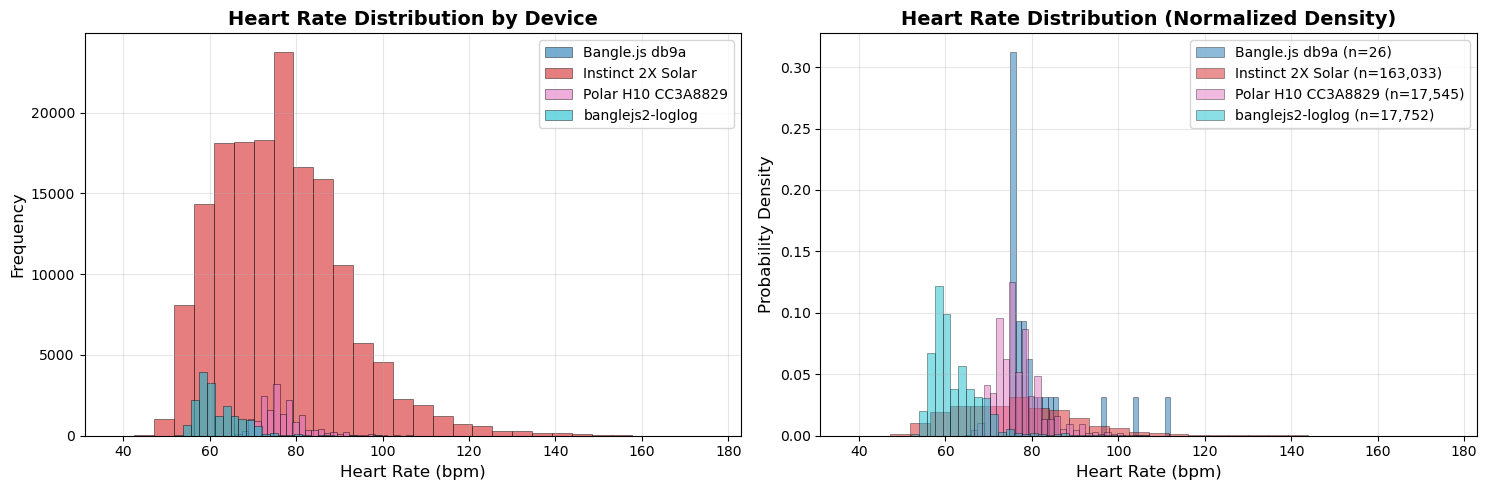

HISTOGRAM STATISTICS

Bangle.js db9a:
  Count: 26
  Mean: 81.04
  Std Dev: 9.17
  Range: 75.00 - 112.00

Instinct 2X Solar:
  Count: 163,033
  Mean: 76.30
  Std Dev: 14.63
  Range: 38.00 - 176.00

Polar H10 CC3A8829:
  Count: 17,545
  Mean: 76.93
  Std Dev: 5.74
  Range: 63.00 - 107.00

banglejs2-loglog:
  Count: 17,752
  Mean: 62.23
  Std Dev: 5.99
  Range: 52.00 - 107.00


In [63]:
#!/usr/bin/env python3
"""
Heart Rate Distribution Histograms
Input: hr_data DataFrame
"""

import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================
NORMALIZED = False  # Set to True to plot normalized HR (0-1), False for bpm
BINS = 30
FIGSIZE = (15, 5)

# =============================================================================
# PLOT HISTOGRAMS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found. Run combine_and_normalize.py first.")
else:
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)
    
    devices = sorted(hr_data['device_name'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(devices)))
    
    # Select column
    hr_column = 'HR_NORMALIZED' if NORMALIZED and 'HR_NORMALIZED' in hr_data.columns else 'HEART_RATE'
    xlabel = 'Normalized Heart Rate (0-1)' if NORMALIZED else 'Heart Rate (bpm)'
    
    # Left: Individual histograms (stacked)
    for device, color in zip(devices, colors):
        device_data = hr_data[hr_data['device_name'] == device][hr_column]
        axes[0].hist(device_data, bins=BINS, alpha=0.6, label=device, 
                    color=color, edgecolor='black', linewidth=0.5)
    
    axes[0].set_title('Heart Rate Distribution by Device', fontsize=14, fontweight='bold')
    axes[0].set_xlabel(xlabel, fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Right: Density plots (normalized for comparison)
    for device, color in zip(devices, colors):
        device_data = hr_data[hr_data['device_name'] == device][hr_column]
        n_samples = len(device_data)
        axes[1].hist(device_data, bins=BINS, alpha=0.5, 
                    label=f'{device} (n={n_samples:,})', 
                    color=color, edgecolor='black', linewidth=0.5,
                    density=True)
    
    axes[1].set_title('Heart Rate Distribution (Normalized Density)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel(xlabel, fontsize=12)
    axes[1].set_ylabel('Probability Density', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("="*80)
    print("HISTOGRAM STATISTICS")
    print("="*80)
    for device in devices:
        device_data = hr_data[hr_data['device_name'] == device][hr_column]
        print(f"\n{device}:")
        print(f"  Count: {len(device_data):,}")
        print(f"  Mean: {device_data.mean():.2f}")
        print(f"  Std Dev: {device_data.std():.2f}")
        print(f"  Range: {device_data.min():.2f} - {device_data.max():.2f}")

CORRELATION ANALYSIS (vs Polar H10 CC3A8829)

Instinct 2X Solar: No overlapping data within 60s

Bangle.js db9a:
  Paired samples: 8
  Correlation (R): 0.688
  R²: 0.473
  MAE: 6.62 bpm
  RMSE: 10.54 bpm
  Mean difference: 5.12 bpm

banglejs2-loglog: No overlapping data within 60s


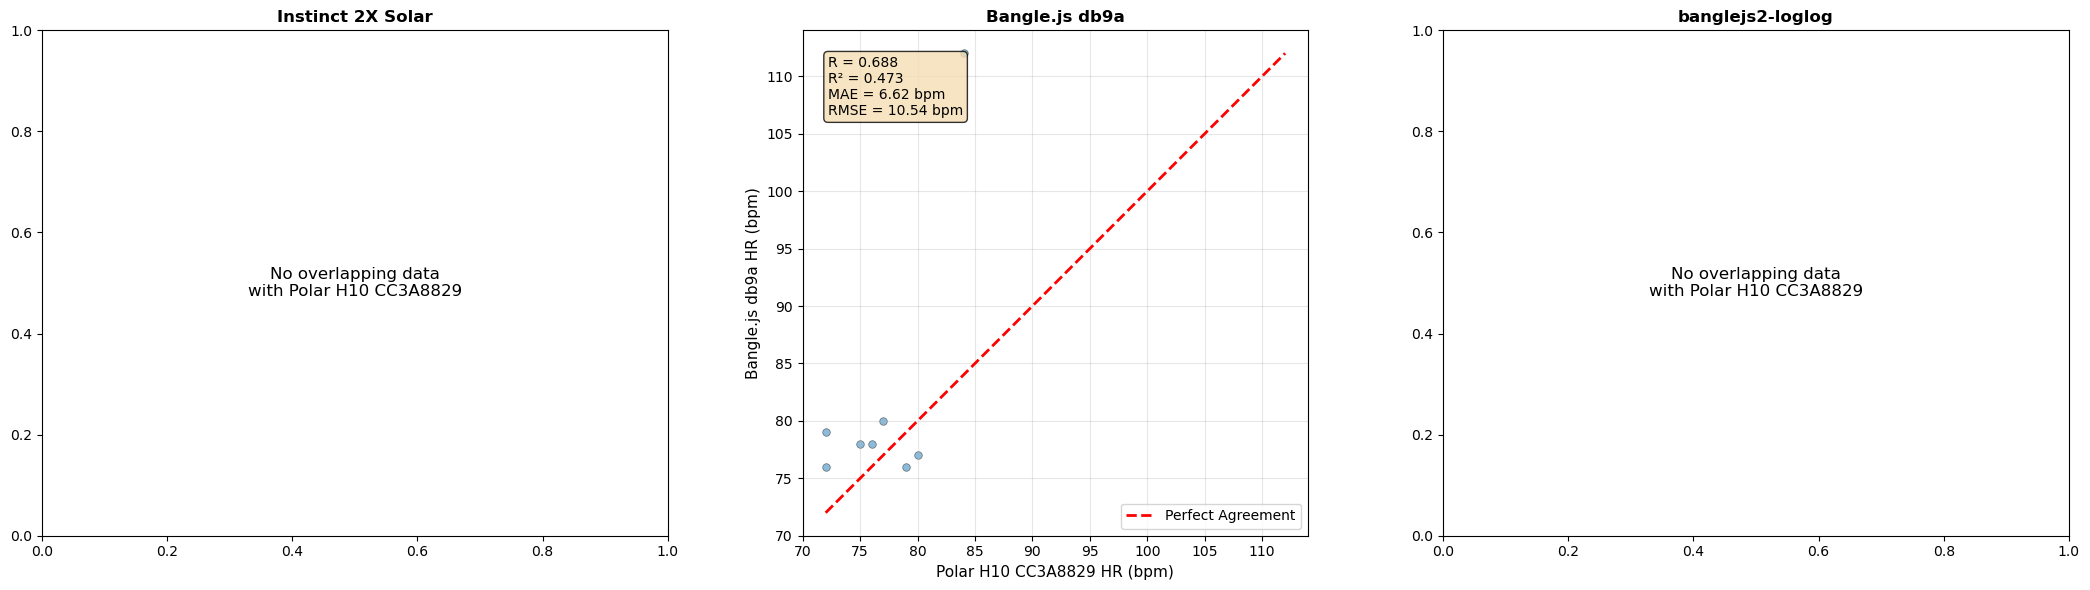

In [62]:
#!/usr/bin/env python3
"""
Device HR Correlation Scatter Plots
Shows how well each device correlates with reference device
Input: hr_data DataFrame
"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================
REFERENCE_DEVICE = 'Polar H10 CC3A8829'  # Reference device (gold standard)
TOLERANCE_SECONDS = 60  # Max time difference for matching measurements
FIGSIZE_PER_DEVICE = 7

# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found. Run combine_and_normalize.py first.")
else:
    # Try to find reference device
    polar_data = hr_data[hr_data['device_name'] == REFERENCE_DEVICE]
    
    if polar_data.empty:
        polar_matches = hr_data[hr_data['device_name'].str.contains('Polar', case=False, na=False)]
        if not polar_matches.empty:
            REFERENCE_DEVICE = polar_matches['device_name'].iloc[0]
            polar_data = hr_data[hr_data['device_name'] == REFERENCE_DEVICE]
            print(f"Using reference device: {REFERENCE_DEVICE}")
    
    if polar_data.empty:
        print(f"Error: Reference device not found in data")
        print(f"Available devices: {list(hr_data['device_name'].unique())}")
    else:
        polar_data = polar_data[['datetime', 'HEART_RATE']].copy()
        polar_data.columns = ['datetime', 'polar_hr']
        
        other_devices = [d for d in hr_data['device_name'].unique() if d != REFERENCE_DEVICE]
        
        if not other_devices:
            print("Error: Need at least one other device for comparison")
        else:
            n_devices = len(other_devices)
            fig, axes = plt.subplots(1, n_devices, figsize=(FIGSIZE_PER_DEVICE*n_devices, 6))
            
            if n_devices == 1:
                axes = [axes]
            
            print("="*80)
            print(f"CORRELATION ANALYSIS (vs {REFERENCE_DEVICE})")
            print("="*80)
            
            for idx, device in enumerate(other_devices):
                device_data = hr_data[hr_data['device_name'] == device][['datetime', 'HEART_RATE']].copy()
                device_data.columns = ['datetime', 'device_hr']
                
                # Merge on nearest timestamps
                merged = pd.merge_asof(
                    device_data.sort_values('datetime'),
                    polar_data.sort_values('datetime'),
                    on='datetime',
                    direction='nearest',
                    tolerance=pd.Timedelta(f'{TOLERANCE_SECONDS}s')
                ).dropna()
                
                if not merged.empty:
                    axes[idx].scatter(merged['polar_hr'], merged['device_hr'], 
                                     alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
                    
                    # Plot perfect agreement line
                    min_val = min(merged['polar_hr'].min(), merged['device_hr'].min())
                    max_val = max(merged['polar_hr'].max(), merged['device_hr'].max())
                    axes[idx].plot([min_val, max_val], [min_val, max_val], 
                                  'r--', linewidth=2, label='Perfect Agreement')
                    
                    # Calculate statistics
                    correlation = merged['polar_hr'].corr(merged['device_hr'])
                    mae = np.abs(merged['device_hr'] - merged['polar_hr']).mean()
                    rmse = np.sqrt(((merged['device_hr'] - merged['polar_hr']) ** 2).mean())
                    
                    # Display stats on plot
                    stats_text = f'R = {correlation:.3f}\nR² = {correlation**2:.3f}\nMAE = {mae:.2f} bpm\nRMSE = {rmse:.2f} bpm'
                    axes[idx].text(0.05, 0.95, stats_text,
                                  transform=axes[idx].transAxes, 
                                  verticalalignment='top',
                                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                                  fontsize=10)
                    
                    axes[idx].set_xlabel(f'{REFERENCE_DEVICE} HR (bpm)', fontsize=11)
                    axes[idx].set_ylabel(f'{device} HR (bpm)', fontsize=11)
                    axes[idx].set_title(f'{device}', fontsize=12, fontweight='bold')
                    axes[idx].legend(loc='lower right')
                    axes[idx].grid(True, alpha=0.3)
                    axes[idx].set_aspect('equal', adjustable='box')
                    
                    # Print statistics
                    print(f"\n{device}:")
                    print(f"  Paired samples: {len(merged):,}")
                    print(f"  Correlation (R): {correlation:.3f}")
                    print(f"  R²: {correlation**2:.3f}")
                    print(f"  MAE: {mae:.2f} bpm")
                    print(f"  RMSE: {rmse:.2f} bpm")
                    print(f"  Mean difference: {(merged['device_hr'] - merged['polar_hr']).mean():.2f} bpm")
                else:
                    axes[idx].text(0.5, 0.5, f'No overlapping data\nwith {REFERENCE_DEVICE}',
                                  ha='center', va='center', transform=axes[idx].transAxes,
                                  fontsize=12)
                    axes[idx].set_title(f'{device}', fontsize=12, fontweight='bold')
                    print(f"\n{device}: No overlapping data within {TOLERANCE_SECONDS}s")
            
            plt.tight_layout()
            plt.show()